#### 1. Import libraries

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
#pip install scikit-learn
#pip install seaborn

#### 2. Read file

In [4]:
df = pd.read_csv("reviews_processed_with_spacy_md.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354200 entries, 0 to 354199
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   firm               354200 non-null  object 
 1   date_review        354200 non-null  object 
 2   overall_rating     354200 non-null  int64  
 3   work_life_balance  354200 non-null  float64
 4   culture_values     354200 non-null  float64
 5   career_opp         354200 non-null  float64
 6   comp_benefits      354200 non-null  float64
 7   senior_mgmt        354200 non-null  float64
 8   recommend          354200 non-null  object 
 9   ceo_approv         354200 non-null  object 
 10  outlook            354200 non-null  object 
 11  headline           352907 non-null  object 
 12  pros               354200 non-null  object 
 13  cons               354197 non-null  object 
 14  status             354200 non-null  object 
 15  experience         354200 non-null  object 
 16  he

In [5]:
df.head()

,firm,date_review,overall_rating,work_life_balance,culture_values,career_opp,comp_benefits,senior_mgmt,recommend,ceo_approv,outlook,headline,pros,cons,status,experience,headline_clean,pros_clean,cons_clean,full_text_clean
0,Apple,2008-01-31,5,3.0,5.0,3.0,4.0,4.0,v,v,o,We make products that poeple enjoy buying and ...,The people we work with are great and I can't ...,You have to be careful because this job can ta...,current,No information,product poeple enjoy buy,people work great not imagine life will produc...,careful job life careful need learn seperate ...,product poeple enjoy buy. people work great no...
1,Apple,2008-02-14,4,4.0,5.0,3.0,4.0,3.0,v,v,o,It is a different job because of all of the di...,The big positive for me is that I really do en...,I suppose that a con would be that there is a ...,current,No information,different job different creative product work,big positive enjoy job apple innovative change...,suppose con hard balance work home life,different job different creative product work....
2,Apple,2008-02-15,5,4.0,5.0,5.0,5.0,5.0,v,v,o,Working at Apple is the hardest job you will e...,When you work at a place like Apple you have a...,The people at Apple are living on the bleeding...,current,No information,work apple hard job love,work place like apple opportunity change way w...,people apple live bleed edge not know future h...,work apple hard job love. work place like appl...
3,Apple,2008-04-20,5,5.0,5.0,5.0,4.0,5.0,v,v,o,"A retail job that is altogether exciting, thri...",Despite the fact that it all boils down to sel...,"As part of their intensive training, there are...",current,No information,retail job altogether exciting thrilling life ...,despite fact boil sell product apple make feel...,intensive training mandatory meeting month pos...,retail job altogether exciting thrilling life ...
4,Apple,2008-04-20,2,3.0,5.0,2.0,3.0,1.0,x,x,o,Worst choice ever.,The benefits for fulltime employees were great...,Too much confidentiality. You couldn't even f...,former,No information,bad choice,benefit fulltime employee great stock option r...,confidentiality not fart get reprimand way fee...,bad choice. benefit fulltime employee great st...


#####  3. Create target variable 'sentiment'

In [6]:
# Remove neutral rating
df = df[df['overall_rating'] != 3].copy()

# Combine texts
df['text'] = df['headline_clean'].fillna('') + ' ' + df['pros_clean'].fillna('') + ' ' + df['cons_clean'].fillna('')

# Classification by the rating (binary rating positive/negative)
df['sentiment'] = df['overall_rating'].apply(lambda x: 'positive' if x > 3 else 'negative')

# Create encoded labels
df['label'] = df['sentiment'].map({'negative': 0, 'positive': 1})

In [7]:
# Verify the targets and labels
df[['overall_rating', 'sentiment', 'label']].head()

,overall_rating,sentiment,label
0,5,positive,1
1,4,positive,1
2,5,positive,1
3,5,positive,1
4,2,negative,0


In [8]:
# save dataset version containing target and labels
df.to_csv('clean_reviews_with_labels.csv', index=False)

##### 4. Verify the balance of 2 categories

In [9]:
df['sentiment'].value_counts(normalize=True)

sentiment
positive    0.810786
negative    0.189214
Name: proportion, dtype: float64

L’échantillon est déséquilibré (81 % d’avis positifs / 19 % négatifs).
Une pondération des classes va être appliquée pour corriger ce déséquilibre (class_weight='balanced').

Le score F1 va être utilisé comme métrique principale, et pas uniquement la précision (accuracy), pour éviter qu’un modèle semble performant simplement en prédisant toujours la classe majoritaire (positive).

##### 5. Split dataset to train and test

In [10]:
X = df['text']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

##### 6. Tester modèle baseline TF-IDF + Régression logistique sur des textes pré-traités

##### TF-IDF vectorization

In [11]:
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')  # it's possible to add ngram_range=(1,2)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

Train logistic regression

In [12]:
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train_tfidf, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

Asessment of the model results

In [13]:
y_pred = model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.54      0.80      0.65     12483
    positive       0.95      0.84      0.89     53492

    accuracy                           0.83     65975
   macro avg       0.74      0.82      0.77     65975
weighted avg       0.87      0.83      0.85     65975

[[ 9977  2506]
 [ 8431 45061]]


Interpretation des résultats:
Le modèle a été entraîné avec une pondération automatique des classes (class_weight='balanced') pour corriger le déséquilibre de la base de données (81 % positifs, 19 % négatifs).

Il atteint une accuracy de 83 % et un F1-score global de 85 %.

La classe minoritaire (négative) est bien détectée avec un rappel de 80 %, bien que la précision soit plus faible (54 %), ce qui signifie que certains avis positifs sont classés à tort comme négatifs.

Globalement, le modèle est robuste pour une première approche, notamment dans la détection d’avis négatifs potentiellement utiles pour les candidats.

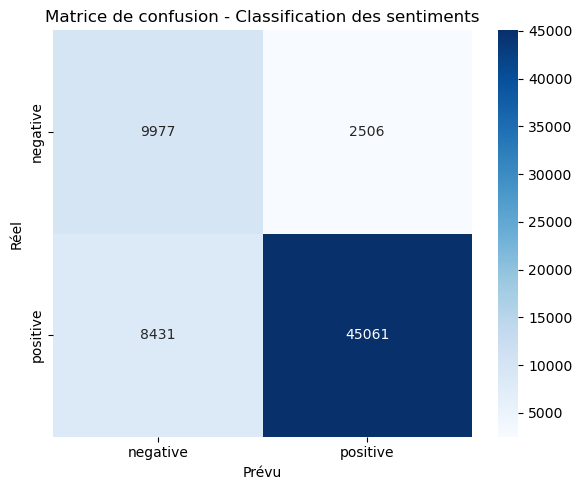

In [14]:
# Create confusion matrix
labels = ['negative', 'positive']
cm = confusion_matrix(y_test, y_pred, labels=labels)

# Visualization
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Prévu')   # Predicted
plt.ylabel('Réel')    # Actual
plt.title('Matrice de confusion - Classification des sentiments')
plt.tight_layout()
plt.show()

            Pred: neg     Pred: pos
##### Real Negative -	                     9977 (True Neg)	    2506 (False Pos)
##### Real Positive - 	                     8422 (False Neg)	    45070 (True Pos)

Interpretation des résultats:
Le modèle a été entraîné avec une pondération automatique des classes (class_weight='balanced') pour corriger le déséquilibre de la base de données (81 % positifs, 19 % négatifs).

Il atteint une accuracy de 83 % et un F1-score global de 85 %.

La classe minoritaire (négative) est bien détectée avec un rappel de 80 %, bien que la précision soit plus faible (54 %), ce qui signifie que certains avis positifs sont classés à tort comme négatifs.

Globalement, le modèle est robuste pour une première approche, notamment dans la détection d’avis négatifs potentiellement utiles pour les candidats.¶

### 7. Tester le modèle après l'apport d'une amélioration  - limiter ou ajuster le vocabulaire TF-IDF

Exemple: TfidfVectorizer(max_features=5000, min_df=5, max_df=0.8)

- max_features : limite le nombre total de mots considérés → plus rapide, moins de bruit ;

- min_df : ignore les mots trop rares ;

- max_df : ignore les mots trop fréquents (souvent non-informatifs).

In [15]:
# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.8, stop_words='english')  
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

#Train logistic regression
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train_tfidf, y_train)

#Show model results
y_pred = model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.54      0.80      0.65     12483
    positive       0.95      0.84      0.89     53492

    accuracy                           0.83     65975
   macro avg       0.74      0.82      0.77     65975
weighted avg       0.87      0.83      0.85     65975

[[ 9986  2497]
 [ 8440 45052]]


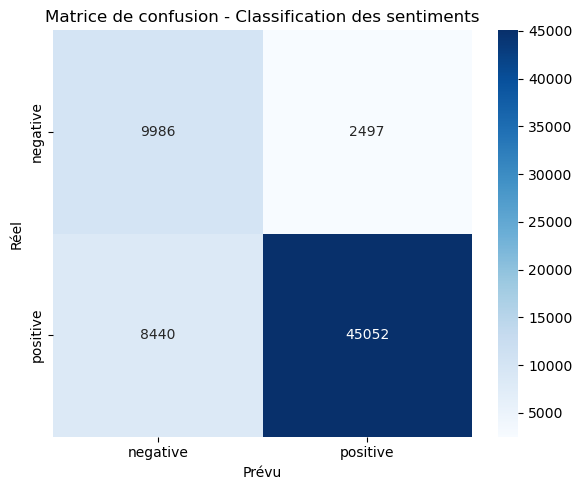

In [16]:
# Create confusion matrix
labels = ['negative', 'positive']
cm = confusion_matrix(y_test, y_pred, labels=labels)

# Visualization
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Prévu')   # Predicted
plt.ylabel('Réel')    # Actual
plt.title('Matrice de confusion - Classification des sentiments')
plt.tight_layout()
plt.show()

#### Les ajustements sur TfidfVectorizer n'ont eu qu’un impact minime, voire négligeable.

Possibles raisons:

- TF-IDF a déjà des limites : il ne capture pas le sens, la structure grammaticale ni la sémantique profonde.
- Les classes sont déséquilibrées — malgré class_weight='balanced', le modèle reste biaisé vers le positif.
- Tes textes sont déjà bien prétraités  -  pas beaucoup à gagner avec l'ajustement du vocabulaire TF-IDF (paramètres min_df, max_df ou max_features)



#### 8. Tenter une GridSearchCV (tester différentes valeurs de C (régularisation) dans LogisticRegression)

In [17]:
from sklearn.model_selection import GridSearchCV

# Determine the list of values of the hyperparameters to be tested 
params = {'C': [0.01, 0.1, 1, 10]}

# GridSearch with Logistic Regression
grid = GridSearchCV(
    LogisticRegression(class_weight='balanced', max_iter=1000),
    params,
    scoring='f1_macro',
    cv=3
)
grid.fit(X_train_tfidf, y_train)

# Best model and result
print("Best params:", grid.best_params_)
print("Best f1_macro score:", grid.best_score_)

Best params: {'C': 1}
Best f1_macro score: 0.7656732007425392


Tester le meilleur modèle

In [18]:
# Chose the model with the best param
best_model = grid.best_estimator_

#Show model results
y_pred = best_model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.54      0.80      0.65     12483
    positive       0.95      0.84      0.89     53492

    accuracy                           0.83     65975
   macro avg       0.74      0.82      0.77     65975
weighted avg       0.87      0.83      0.85     65975

[[ 9986  2497]
 [ 8440 45052]]


#### On a obtenu des résultats quasiment identiques avec ou sans GridSearch

Possibles raisons:
- Le modèle n’était pas trop sous-ajusté ni surajusté au départ.
- La régularisation C=1, qui est la valeur par défaut, était déjà suffisamment bien équilibrée entre biais et variance.
- Cela peut aussi indiquer que la limite des performances provient davantage des données ou de la méthode de vectorisation (TF-IDF), et non pas d’un mauvais réglage du modèle.

#### La suite logique serait donc de tester une méthode plus riche en représentation comme les embeddings de mots (Word2Vec par ex) ou les Transformers (BERT), pour voir si cela permet au modèle de mieux capturer la nuance des sentiments dans les textes.